# [LO 1, LO 2, LO 3 & LO 4, 25%] Deep Learning mengalami perkembangan yang sangat pesat dalambeberapa tahun belakangan ini. Salah satunya dalam bidang Generative AI. Cikal bakal dari bidang  ini adalah arsitektur yang disebut sebagai generative adversarial network (GAN).
## a. [LO 1, LO 2, LO 3, 5 poin] Jelaskan cara kerja dari arsitektur tersebut yang dideskripsikan dalamgambar di bawah ini:

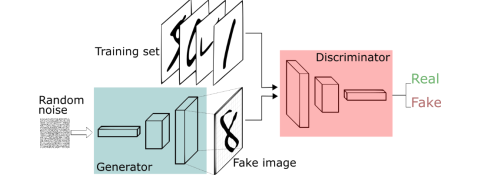

### jawaban: 
gambar diatas merupkan arsitektur dari GAN (generatrive adversarial network) dimana network ini memiliki 2 komponen utama generator dan discirminator dengan cara kerja seperti berikut,

generator akan menerima input berupa noise acak dan dilatih dengna tujuan untuk menghasilkan gambar yang menyerupai gambar asli dari dataset, tujuannya adalah untuk menghasilkan gambar yang tidak bisa dibedakan dari gambar asli oleh discriminator

discriminator akan menerima gambar sebagai input, baik itu asli dari dataset ataupun gambar palsu dari generator, outputnya adalah probabilitas apakah gambar adalah asli atau palsu, tujuannya adalah untuk membedakan gambar yang asli dan palsu dengan benar

dalam proses training maka model akan berkerja seperti ini,

1. Generator membuat gambar palsu dari noise acak.
2. Discriminator dilatih dengan gambar asli (label 1) dan gambar palsu (label 0).
3. Generator dilatih untuk menipu discriminator agar menganggap gambar palsu sebagai asli (label 1).
4. Kedua jaringan berkompetisi:
5. Generator semakin baik menghasilkan gambar realistis.
6. Discriminator semakin baik membedakan gambar asli dan palsu.

## b. [LO 3, LO 4, 15 poin] Buatlah arsitektur untuk image generation sesuai dengan gambar arsitektur GAN berikut ini. Lakukan evaluasi kesamaan distribusi citra dengan menggunakan Fréchet Inception Distance (FID) pada data test.

In [19]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplearning-uas-2-and-3/t10k-labels-idx1-ubyte
/kaggle/input/deeplearning-uas-2-and-3/t10k-images-idx3-ubyte
/kaggle/input/deeplearning-uas-2-and-3/train-labels-idx1-ubyte
/kaggle/input/deeplearning-uas-2-and-3/train-images-idx3-ubyte


In [2]:
def read_mnist_images(filepath, class_labels=None, scale=True):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        # Read image data
        raw_data = f.read()
        images = np.frombuffer(raw_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)
        
        # Scale images to range [0, 1]
        if scale:
            images = (images - 127.5) / 127.5

        return images

def read_mnist_labels(filepath, class_labels=None):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Read label data
        raw_data = f.read()
        labels = np.frombuffer(raw_data, dtype=np.uint8)
        return labels
    
# load n scale the images
train_images = read_mnist_images('/kaggle/input/deeplearning-uas-2-and-3/train-images-idx3-ubyte')
train_labels = read_mnist_labels('/kaggle/input/deeplearning-uas-2-and-3/train-labels-idx1-ubyte')
test_images = read_mnist_images('/kaggle/input/deeplearning-uas-2-and-3/t10k-images-idx3-ubyte')
test_labels = read_mnist_labels('/kaggle/input/deeplearning-uas-2-and-3/t10k-labels-idx1-ubyte')

# unscaled
train_images_unscaled = read_mnist_images('/kaggle/input/deeplearning-uas-2-and-3/train-images-idx3-ubyte', scale=False)
test_images_unscaled = read_mnist_images('/kaggle/input/deeplearning-uas-2-and-3/t10k-images-idx3-ubyte', scale=False)


# Print shape of the data
print("Train images shape (unscaled):", train_images_unscaled.shape)
print("Train images shape (scaled):", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape (unscaled):", test_images_unscaled.shape)
print("Test images shape (scaled):", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape (unscaled): (60000, 28, 28)
Train images shape (scaled): (60000, 28, 28)
Train labels shape: (60000,)
Test images shape (unscaled): (10000, 28, 28)
Test images shape (scaled): (10000, 28, 28)
Test labels shape: (10000,)


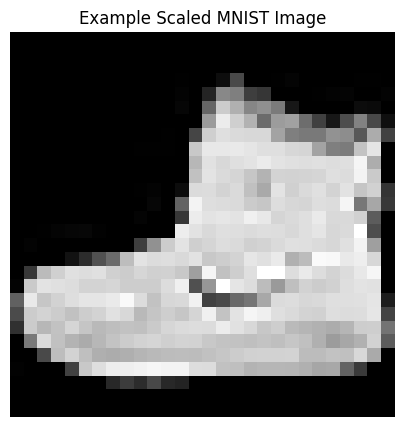

In [64]:
# Show an example of a scaled image
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(train_images_unscaled[0], cmap='gray')
plt.title(f'Example Scaled MNIST Image')
plt.axis('off')
plt.show()

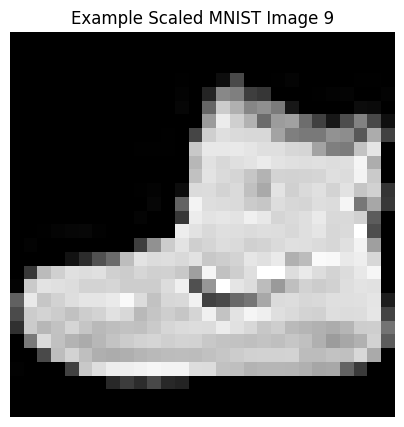

In [65]:
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')
plt.title(f'Example Scaled MNIST Image {train_labels[0]}')
plt.axis('off')
plt.show()

In [66]:
train_images.shape

(60000, 28, 28)

In [3]:
# Concatenate train and test images
merged_images = np.concatenate((train_images, test_images), axis=0)

# Concatenate train and test labels
merged_labels = np.concatenate((train_labels, test_labels), axis=0)

# Print the shape of merged data to verify
print("Merged Images Shape:", merged_images.shape)
print("Merged Labels Shape:", merged_labels.shape)

Merged Images Shape: (70000, 28, 28)
Merged Labels Shape: (70000,)


In [4]:
# Define class labels to filter
class_labels = [4, 5]  # Class 4 corresponds to 'Coat', Class 5 corresponds to 'Sandal'

# Initialize lists to store filtered images and labels
filtered_images = []
filtered_labels = []

# Iterate through merged data to filter based on class labels
for i in range(len(merged_labels)):
    if merged_labels[i] in class_labels:
        filtered_images.append(merged_images[i])
        filtered_labels.append(merged_labels[i])

# Convert lists to numpy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

# Print the shape of filtered data to verify
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (14000, 28, 28)
Filtered Labels Shape: (14000,)


In [21]:
print(f'image shape: {filtered_images[1]}, label = {filtered_labels[1]}')

image shape: [[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -0.99215686 -0.99215686 -1.         -1.         -1.
  -1.         -1.         -1.         -1.          0.28627451 -0.60784314
  -1.         -0.94509804 -1.         -1.        ]
 [-1.         -1.         -1.     

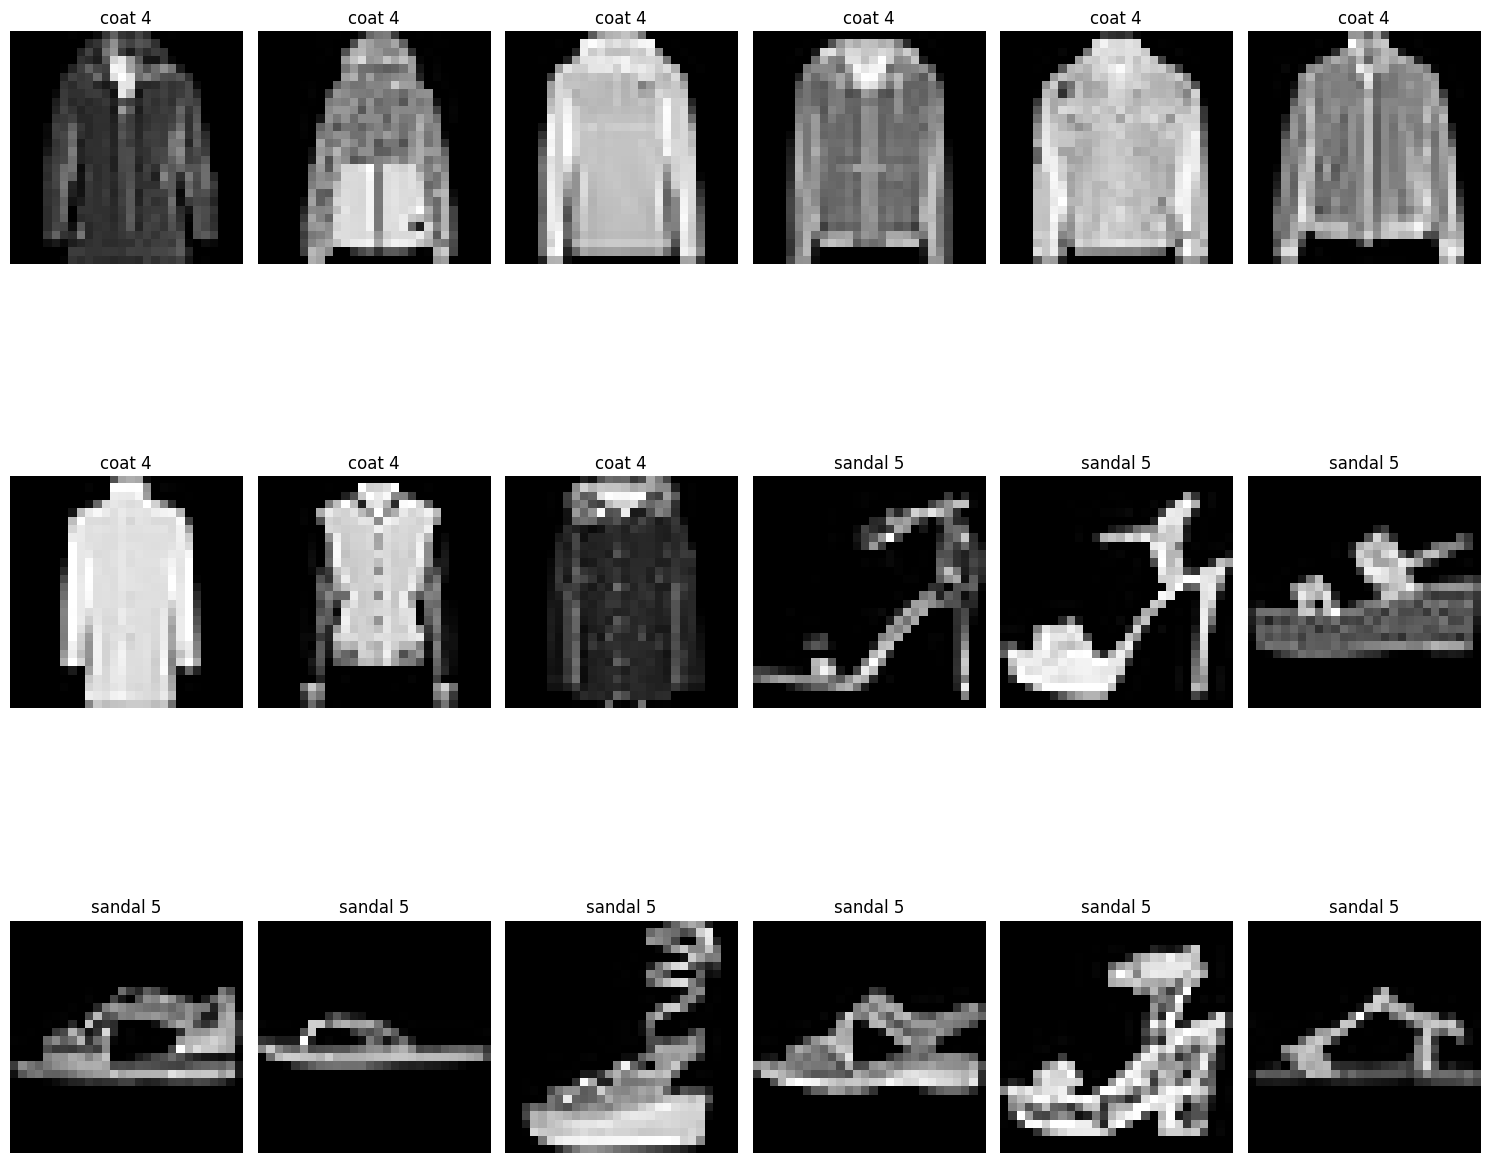

In [70]:
# Display 9 'Coat' and 9 'Sandal' images
num_coat = 0
num_sandal = 0
plt.figure(figsize=(15, 15))
for i in range(len(filtered_images)):
    if filtered_labels[i] == 4 and num_coat < 9:  # Filter 'Coat' and limit to 9 images
        plt.subplot(3, 6, num_coat + 1)
        plt.imshow(filtered_images[i], cmap='gray')
        plt.title(f'coat {filtered_labels[i]}')
        plt.axis('off')
        num_coat += 1
    elif filtered_labels[i] == 5 and num_sandal < 9:  # Filter 'Sandal' and limit to 9 images
        plt.subplot(3, 6, 9 + num_sandal + 1)
        plt.imshow(filtered_images[i], cmap='gray')
        plt.title(f'sandal {filtered_labels[i]}')
        plt.axis('off')
        num_sandal += 1
    if num_coat == 9 and num_sandal == 9:  # Break if both conditions are met
        break
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Reshape filtered_images to include channel dimension
filtered_images = filtered_images.reshape((-1, 28, 28, 1))

# Split data into train and test with ratio 80:20
train_images, test_images, train_labels, test_labels = train_test_split(filtered_images, filtered_labels, test_size=0.2, random_state=42)

# Split train data into train and validation with ratio 90:10
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

# Print the number of data points in each set
print(f"Jumlah data train: {len(train_images)}")
print(f"Jumlah data validation: {len(val_images)}")
print(f"Jumlah data test: {len(test_images)}")

Jumlah data train: 10080
Jumlah data validation: 1120
Jumlah data test: 2800


In [72]:
from tensorflow.keras import layers, models

# Generator
generator = models.Sequential([
    layers.Dense(1024, input_shape=(100,)),
    layers.Dense(512),
    layers.Dense(256),
    layers.Dense(128),
    layers.Dense(28*28),
    layers.Reshape((28, 28, 1))
])

# Discriminator
discriminator = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(512),
    layers.Dense(1024),
    layers.Dense(1024),
    layers.Dense(512),
    layers.Dense(1)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
epochs = 300
batch_size = 128
noise_shape=100

Epoch 1/300


100%|██████████| 79/79 [00:10<00:00,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


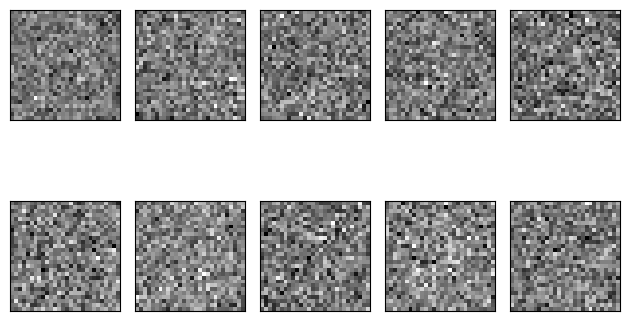

Epoch 2/300


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Epoch 3/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 4/300


100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


Epoch 5/300


100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


Epoch 6/300


100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Epoch 7/300


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Epoch 8/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 9/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 10/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 11/300


100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


Epoch 12/300


100%|██████████| 79/79 [00:05<00:00, 13.33it/s]


Epoch 13/300


100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


Epoch 14/300


100%|██████████| 79/79 [00:05<00:00, 14.47it/s]


Epoch 15/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 16/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 17/300


100%|██████████| 79/79 [00:05<00:00, 13.92it/s]


Epoch 18/300


100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


Epoch 19/300


100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


Epoch 20/300


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Epoch 21/300


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 22/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 23/300


100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Epoch 24/300


100%|██████████| 79/79 [00:05<00:00, 13.51it/s]


Epoch 25/300


100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


Epoch 26/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 27/300


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


Epoch 28/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 29/300


100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Epoch 30/300


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Epoch 31/300


100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


Epoch 32/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 33/300


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Epoch 34/300


100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Epoch 35/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 36/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 37/300


100%|██████████| 79/79 [00:05<00:00, 14.19it/s]


Epoch 38/300


100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


Epoch 39/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 40/300


100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 41/300


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


Epoch 42/300


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 43/300


100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Epoch 44/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 45/300


100%|██████████| 79/79 [00:05<00:00, 14.01it/s]


Epoch 46/300


100%|██████████| 79/79 [00:05<00:00, 13.99it/s]


Epoch 47/300


100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 48/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 49/300


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 50/300


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 51/300


100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 52/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 53/300


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Epoch 54/300


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


Epoch 55/300


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


Epoch 56/300


100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


Epoch 57/300


100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Epoch 58/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 59/300


100%|██████████| 79/79 [00:05<00:00, 14.08it/s]


Epoch 60/300


100%|██████████| 79/79 [00:05<00:00, 13.94it/s]


Epoch 61/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 62/300


100%|██████████| 79/79 [00:06<00:00, 12.80it/s]


Epoch 63/300


100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


Epoch 64/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 65/300


100%|██████████| 79/79 [00:05<00:00, 14.11it/s]


Epoch 66/300


100%|██████████| 79/79 [00:05<00:00, 14.05it/s]


Epoch 67/300


100%|██████████| 79/79 [00:05<00:00, 13.99it/s]


Epoch 68/300


100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


Epoch 69/300


100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Epoch 70/300


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 71/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 72/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 73/300


100%|██████████| 79/79 [00:05<00:00, 13.23it/s]


Epoch 74/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 75/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 76/300


100%|██████████| 79/79 [00:05<00:00, 13.42it/s]


Epoch 77/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 78/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 79/300


100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Epoch 80/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 81/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 82/300


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 83/300


100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Epoch 84/300


100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Epoch 85/300


100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


Epoch 86/300


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


Epoch 87/300


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Epoch 88/300


100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Epoch 89/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 90/300


100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


Epoch 91/300


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


Epoch 92/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 93/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 94/300


100%|██████████| 79/79 [00:05<00:00, 14.16it/s]


Epoch 95/300


100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 96/300


100%|██████████| 79/79 [00:05<00:00, 13.67it/s]


Epoch 97/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 98/300


100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


Epoch 99/300


100%|██████████| 79/79 [00:05<00:00, 14.00it/s]


Epoch 100/300


100%|██████████| 79/79 [00:05<00:00, 14.04it/s]


Epoch 101/300


100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


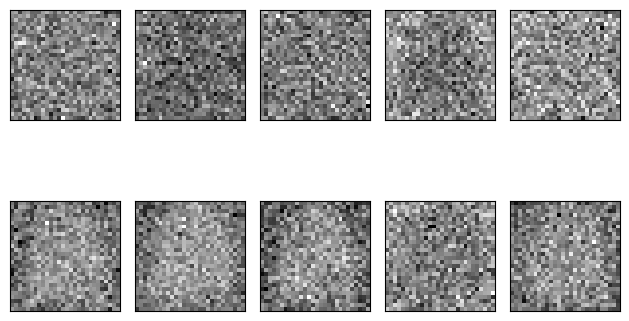

Epoch 102/300


100%|██████████| 79/79 [00:06<00:00, 12.79it/s]


Epoch 103/300


100%|██████████| 79/79 [00:05<00:00, 13.87it/s]


Epoch 104/300


100%|██████████| 79/79 [00:05<00:00, 13.45it/s]


Epoch 105/300


100%|██████████| 79/79 [00:05<00:00, 13.74it/s]


Epoch 106/300


100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Epoch 107/300


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Epoch 108/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 109/300


100%|██████████| 79/79 [00:05<00:00, 14.02it/s]


Epoch 110/300


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 111/300


100%|██████████| 79/79 [00:05<00:00, 13.77it/s]


Epoch 112/300


100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 113/300


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


Epoch 114/300


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


Epoch 115/300


100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 116/300


100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


Epoch 117/300


100%|██████████| 79/79 [00:05<00:00, 13.65it/s]


Epoch 118/300


100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Epoch 119/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 120/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 121/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 122/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 123/300


100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Epoch 124/300


100%|██████████| 79/79 [00:05<00:00, 14.08it/s]


Epoch 125/300


100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Epoch 126/300


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 127/300


100%|██████████| 79/79 [00:05<00:00, 13.95it/s]


Epoch 128/300


100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Epoch 129/300


100%|██████████| 79/79 [00:05<00:00, 13.31it/s]


Epoch 130/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 131/300


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Epoch 132/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 133/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 134/300


100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 135/300


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


Epoch 136/300


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


Epoch 137/300


100%|██████████| 79/79 [00:05<00:00, 14.42it/s]


Epoch 138/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 139/300


100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 140/300


100%|██████████| 79/79 [00:05<00:00, 13.30it/s]


Epoch 141/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 142/300


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


Epoch 143/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 144/300


100%|██████████| 79/79 [00:05<00:00, 14.15it/s]


Epoch 145/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 146/300


100%|██████████| 79/79 [00:05<00:00, 13.42it/s]


Epoch 147/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 148/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 149/300


100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


Epoch 150/300


100%|██████████| 79/79 [00:05<00:00, 13.45it/s]


Epoch 151/300


100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 152/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 153/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 154/300


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Epoch 155/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 156/300


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Epoch 157/300


100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Epoch 158/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 159/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 160/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 161/300


100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


Epoch 162/300


100%|██████████| 79/79 [00:06<00:00, 12.51it/s]


Epoch 163/300


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Epoch 164/300


100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


Epoch 165/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 166/300


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


Epoch 167/300


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 168/300


100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Epoch 169/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 170/300


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Epoch 171/300


100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


Epoch 172/300


100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


Epoch 173/300


100%|██████████| 79/79 [00:05<00:00, 13.75it/s]


Epoch 174/300


100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


Epoch 175/300


100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


Epoch 176/300


100%|██████████| 79/79 [00:05<00:00, 14.11it/s]


Epoch 177/300


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Epoch 178/300


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Epoch 179/300


100%|██████████| 79/79 [00:06<00:00, 12.77it/s]


Epoch 180/300


100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 181/300


100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


Epoch 182/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 183/300


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 184/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 185/300


100%|██████████| 79/79 [00:06<00:00, 13.06it/s]


Epoch 186/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 187/300


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


Epoch 188/300


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 189/300


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 190/300


100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Epoch 191/300


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


Epoch 192/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 193/300


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Epoch 194/300


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 195/300


100%|██████████| 79/79 [00:05<00:00, 14.11it/s]


Epoch 196/300


100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Epoch 197/300


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Epoch 198/300


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Epoch 199/300


100%|██████████| 79/79 [00:05<00:00, 13.89it/s]


Epoch 200/300


100%|██████████| 79/79 [00:05<00:00, 13.80it/s]


Epoch 201/300


100%|██████████| 79/79 [00:06<00:00, 12.19it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


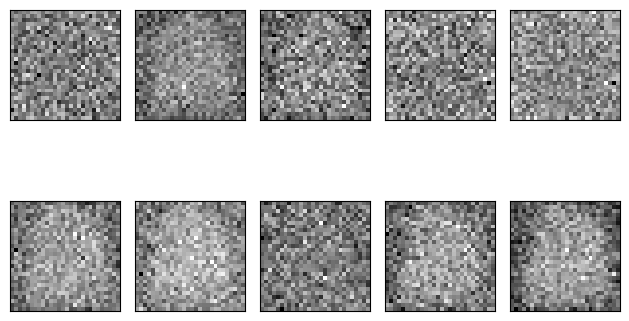

Epoch 202/300


100%|██████████| 79/79 [00:05<00:00, 13.96it/s]


Epoch 203/300


100%|██████████| 79/79 [00:05<00:00, 13.80it/s]


Epoch 204/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 205/300


100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


Epoch 206/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 207/300


100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Epoch 208/300


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]


Epoch 209/300


100%|██████████| 79/79 [00:05<00:00, 14.10it/s]


Epoch 210/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 211/300


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


Epoch 212/300


100%|██████████| 79/79 [00:06<00:00, 12.80it/s]


Epoch 213/300


100%|██████████| 79/79 [00:05<00:00, 13.95it/s]


Epoch 214/300


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]


Epoch 215/300


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Epoch 216/300


100%|██████████| 79/79 [00:05<00:00, 14.04it/s]


Epoch 217/300


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 218/300


100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Epoch 219/300


100%|██████████| 79/79 [00:05<00:00, 13.78it/s]


Epoch 220/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 221/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 222/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 223/300


100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Epoch 224/300


100%|██████████| 79/79 [00:05<00:00, 13.67it/s]


Epoch 225/300


100%|██████████| 79/79 [00:05<00:00, 13.81it/s]


Epoch 226/300


100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 227/300


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


Epoch 228/300


100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


Epoch 229/300


100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Epoch 230/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 231/300


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


Epoch 232/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 233/300


100%|██████████| 79/79 [00:05<00:00, 14.13it/s]


Epoch 234/300


100%|██████████| 79/79 [00:05<00:00, 13.58it/s]


Epoch 235/300


100%|██████████| 79/79 [00:05<00:00, 13.85it/s]


Epoch 236/300


100%|██████████| 79/79 [00:05<00:00, 14.05it/s]


Epoch 237/300


100%|██████████| 79/79 [00:05<00:00, 14.02it/s]


Epoch 238/300


100%|██████████| 79/79 [00:05<00:00, 14.08it/s]


Epoch 239/300


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Epoch 240/300


100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


Epoch 241/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 242/300


100%|██████████| 79/79 [00:05<00:00, 14.09it/s]


Epoch 243/300


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


Epoch 244/300


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Epoch 245/300


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


Epoch 246/300


100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


Epoch 247/300


100%|██████████| 79/79 [00:05<00:00, 13.81it/s]


Epoch 248/300


100%|██████████| 79/79 [00:05<00:00, 14.15it/s]


Epoch 249/300


100%|██████████| 79/79 [00:05<00:00, 13.98it/s]


Epoch 250/300


100%|██████████| 79/79 [00:05<00:00, 14.08it/s]


Epoch 251/300


100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


Epoch 252/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 253/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 254/300


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


Epoch 255/300


100%|██████████| 79/79 [00:05<00:00, 13.53it/s]


Epoch 256/300


100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


Epoch 257/300


100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 258/300


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Epoch 259/300


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


Epoch 260/300


100%|██████████| 79/79 [00:05<00:00, 14.47it/s]


Epoch 261/300


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


Epoch 262/300


100%|██████████| 79/79 [00:05<00:00, 13.32it/s]


Epoch 263/300


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Epoch 264/300


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 265/300


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Epoch 266/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 267/300


100%|██████████| 79/79 [00:05<00:00, 14.51it/s]


Epoch 268/300


100%|██████████| 79/79 [00:06<00:00, 13.11it/s]


Epoch 269/300


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 270/300


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 271/300


100%|██████████| 79/79 [00:05<00:00, 14.42it/s]


Epoch 272/300


100%|██████████| 79/79 [00:05<00:00, 14.50it/s]


Epoch 273/300


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


Epoch 274/300


100%|██████████| 79/79 [00:05<00:00, 13.29it/s]


Epoch 275/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 276/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 277/300


100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 278/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 279/300


100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Epoch 280/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 281/300


100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Epoch 282/300


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


Epoch 283/300


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 284/300


100%|██████████| 79/79 [00:05<00:00, 14.30it/s]


Epoch 285/300


100%|██████████| 79/79 [00:05<00:00, 13.23it/s]


Epoch 286/300


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Epoch 287/300


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Epoch 288/300


100%|██████████| 79/79 [00:05<00:00, 14.48it/s]


Epoch 289/300


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


Epoch 290/300


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 291/300


100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Epoch 292/300


100%|██████████| 79/79 [00:05<00:00, 14.09it/s]


Epoch 293/300


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


Epoch 294/300


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


Epoch 295/300


100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 296/300


100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Epoch 297/300


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Epoch 298/300


100%|██████████| 79/79 [00:05<00:00, 14.23it/s]


Epoch 299/300


100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


Epoch 300/300


100%|██████████| 79/79 [00:05<00:00, 14.35it/s]

Training is complete


In [74]:
from tqdm import tqdm

# Optimizers
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


# Training loop
with tf.device('/gpu:0'):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for image_batch in tqdm(tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)):
            train_step(image_batch)

        # Plotting generated images at the start and then after every save_interval epoch
        if epoch % 100 == 0:
            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, noise_shape)))

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

print('Training is complete')

In [75]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Text(0.5, 1.0, 'How the noise looks')

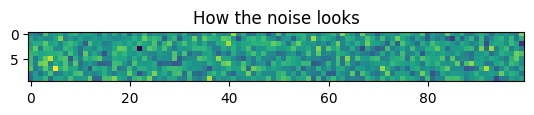

In [76]:
plt.imshow(noise)
plt.title('How the noise looks')

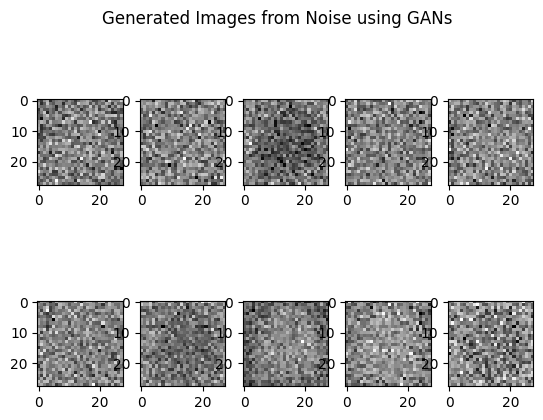

In [77]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

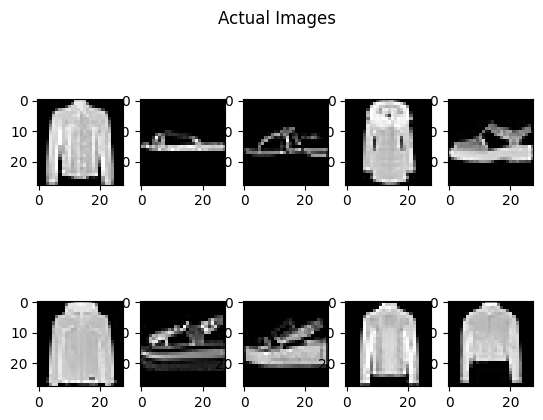

In [78]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(train_images[idx].reshape(28,28),cmap='gray')
        idx+=10

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

def calculate_fid(real_images, generated_images):
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299))
        images = tf.image.grayscale_to_rgb(images)
        return images
    
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)
    
    real_activations = inception_model.predict(real_images)
    generated_activations = inception_model.predict(generated_images)
    
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))  # Perubahan di sini
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

32/32 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step
FID Score: 4.5494910000816705e+67


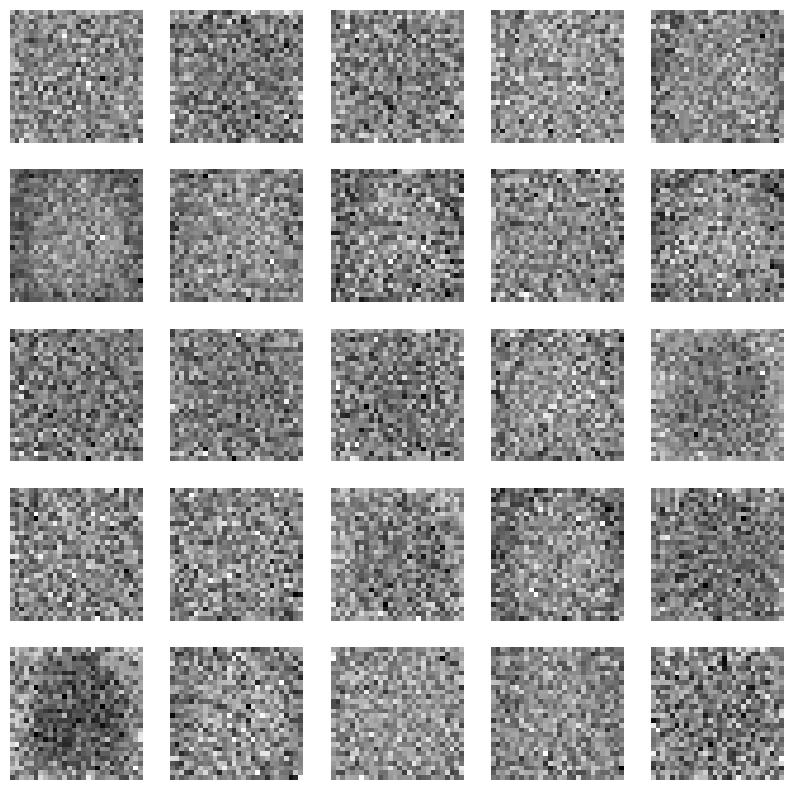

In [80]:
# Generate fake images
noise = tf.random.normal([1000, 100])
generated_images = generator(noise, training=False)

# Calculate FID
fid = calculate_fid(test_images[:1000], generated_images)
print(f"FID Score: {fid}")

# Display some generated images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

jika dilihat disini sebenernya model tidak dapat menghasilkan apa apa hanya noise setelah 300 epoch, dimana ini bukan lah hasil yang diingin kan oleh kita, menurut saya terhadap 2 hipotesa, 

1. model tidak dapat membuat hasil karena tidak ada layer activation sehingga hasilnya malah hanya buram
2. model tidak ditrain dengan benar.

kedua hipotesa ini saya uji dengan model 2 dan 3 yang dibawah

tapi dengan hasil noise ini FID yang didapat cukup rendah dan itu mungkin dapat disebabkan karena noise random yang menyebabkan hasil dari pada evaluasinya menjadi cukup rendah karena warna pixelnya berada diarea tertentu yang cukup significant terhadap gambar asli 

## PENGUJIAN HIPOTESA

In [7]:
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout
from tensorflow.keras import models

In [5]:
generator_2 = models.Sequential()
generator_2.add(Dense(512,input_shape=[100]))
generator_2.add(LeakyReLU(alpha=0.2))
generator_2.add(BatchNormalization(momentum=0.8))
generator_2.add(Dense(256))
generator_2.add(LeakyReLU(alpha=0.2))
generator_2.add(BatchNormalization(momentum=0.8))
generator_2.add(Dense(128))
generator_2.add(LeakyReLU(alpha=0.2))
generator_2.add(BatchNormalization(momentum=0.8))
generator_2.add(Dense(784))
generator_2.add(Reshape([28,28,1]))

generator_2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [6]:
discriminator_2= models.Sequential()
discriminator_2.add(Dense(1,input_shape=[28,28,1]))
discriminator_2.add(Flatten())
discriminator_2.add(Dense(256))
discriminator_2.add(LeakyReLU(alpha=0.2))
discriminator_2.add(Dropout(0.5))
discriminator_2.add(Dense(128))
discriminator_2.add(LeakyReLU(alpha=0.2))
discriminator_2.add(Dropout(0.5))
discriminator_2.add(Dense(64))
discriminator_2.add(LeakyReLU(alpha=0.2))
discriminator_2.add(Dropout(0.5))
discriminator_2.add(Dense(1,activation='sigmoid'))

discriminator_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,179 (946.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
GAN = models.Sequential([generator_2,discriminator_2])
discriminator_2.compile(optimizer='adam',loss='binary_crossentropy')
discriminator_2.trainable = False

In [8]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       320,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       242,179 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,835 (2.15 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 243,971 (953.01 KB)

In [11]:
epochs = 150
batch_size = 128
noise_shape=100

In [12]:
import tensorflow as tf
from tqdm import tqdm
# Optimizers
# Loss functions
cross_entropy_2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_2_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_2_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape_2, tf.GradientTape() as disc_tape_2:
        generated_images = generator_2(noise, training=True)

        real_output = discriminator_2(images, training=True)
        fake_output = discriminator_2(generated_images, training=True)

        gen_loss = cross_entropy_2(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy_2(tf.ones_like(real_output), real_output) + \
                    cross_entropy_2(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator_2 = gen_tape_2.gradient(gen_loss, generator_2.trainable_variables)
    gradients_of_discriminator_2 = disc_tape_2.gradient(disc_loss, discriminator_2.trainable_variables)




# Training loop
with tf.device('/gpu:0'):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for image_batch in tqdm(tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)):
            train_step(image_batch)

        # Plotting generated images at the start and then after every save_interval epoch
        if epoch % 50 == 0:
            samples = 10
            noise = np.random.normal(loc=0, scale=1, size=(samples, 100))
            x_fake = generator_2.predict(noise)

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

print('Training is complete')

Epoch 1/150


  0%|          | 0/79 [00:00<?, ?it/s]


NameError: in user code:

    File "/tmp/ipykernel_34/3168695176.py", line 15, in train_step  *
        generated_images = generator_2(noise, training=True)

    NameError: name 'generator_2' is not defined


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step
FID Score: -1.9615942923083377e+56


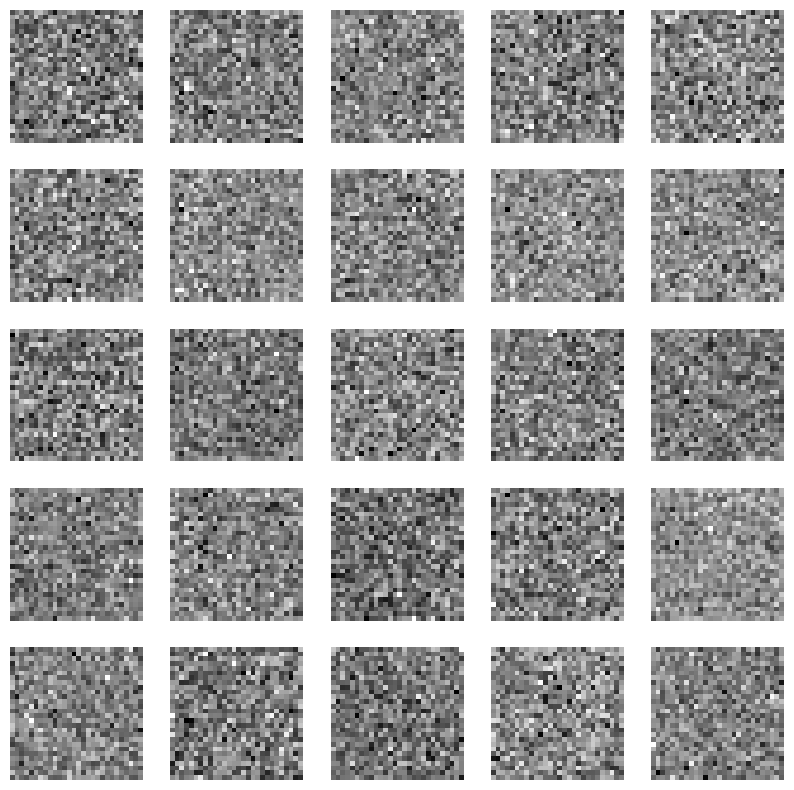

In [30]:
# Generate fake images
noise = tf.random.normal([1000, 100])
generated_images_2 = generator_2(noise, training=False)

# Calculate FID
fid = calculate_fid(test_images[:1000], generated_images_2)
print(f"FID Score: {fid}")

# Display some generated images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images_2[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Model 2: model 2 memiliki arsitektur yang berbeda dari pada model satu dimana dia memiliki fungsi aktivasi tetapi jika kita liat disini setelah 150 epoch yang telah dijalankan hasilnya tetap buram, ini dapat berarti bahwa meskipun dengan model yang memiliki fungsi aktivasi, belum tentu model dapat menghasilkan hasil yang serupa dengan gambar asli

In [8]:
generator_3 = models.Sequential()
generator_3.add(Dense(512,input_shape=[100]))
generator_3.add(LeakyReLU(alpha=0.2))
generator_3.add(BatchNormalization(momentum=0.8))
generator_3.add(Dense(256))
generator_3.add(LeakyReLU(alpha=0.2))
generator_3.add(BatchNormalization(momentum=0.8))
generator_3.add(Dense(128))
generator_3.add(LeakyReLU(alpha=0.2))
generator_3.add(BatchNormalization(momentum=0.8))
generator_3.add(Dense(784))
generator_3.add(Reshape([28,28,1]))

generator_3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
discriminator_3 = models.Sequential()
discriminator_3.add(Dense(1,input_shape=[28,28,1]))
discriminator_3.add(Flatten())
discriminator_3.add(Dense(256))
discriminator_3.add(LeakyReLU(alpha=0.2))
discriminator_3.add(Dropout(0.5))
discriminator_3.add(Dense(128))
discriminator_3.add(LeakyReLU(alpha=0.2))
discriminator_3.add(Dropout(0.5))
discriminator_3.add(Dense(64))
discriminator_3.add(LeakyReLU(alpha=0.2))
discriminator_3.add(Dropout(0.5))
discriminator_3.add(Dense(1,activation='sigmoid'))

discriminator_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,179 (946.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
GAN = models.Sequential([generator_3,discriminator_3])
discriminator_3.compile(optimizer='adam',loss='binary_crossentropy')
discriminator_3.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [11]:
epochs = 10
batch_size = 100
noise_shape=100

In [12]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [13]:
# Set up GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


Currently on Epoch 1


I0000 00:00:1720404005.198768     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720404010.839141     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720404015.409955     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720404022.615057     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


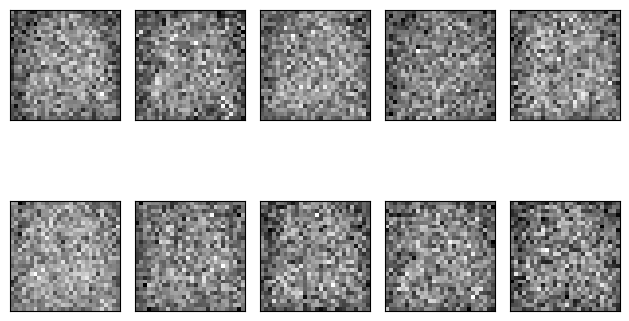

Currently on Epoch 2
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 3
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 4
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently

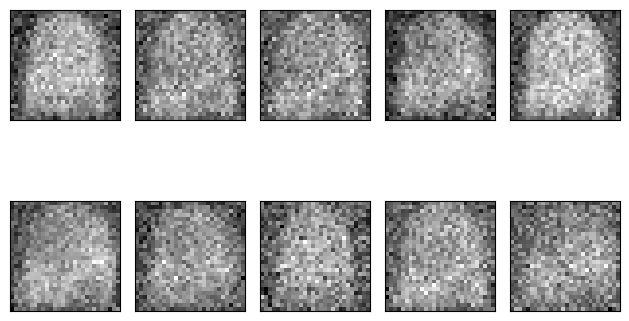

Currently on Epoch 5
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 6
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 7
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently

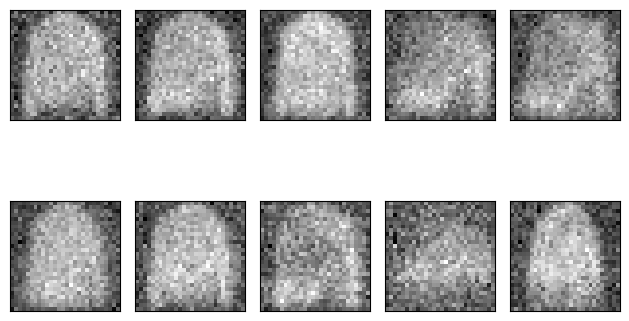

Currently on Epoch 8
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 9
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currently on batch number 60 of 100
	Currently on batch number 70 of 100
	Currently on batch number 80 of 100
	Currently on batch number 90 of 100
	Currently on batch number 100 of 100
Currently on Epoch 10
	Currently on batch number 10 of 100
	Currently on batch number 20 of 100
	Currently on batch number 30 of 100
	Currently on batch number 40 of 100
	Currently on batch number 50 of 100
	Currentl

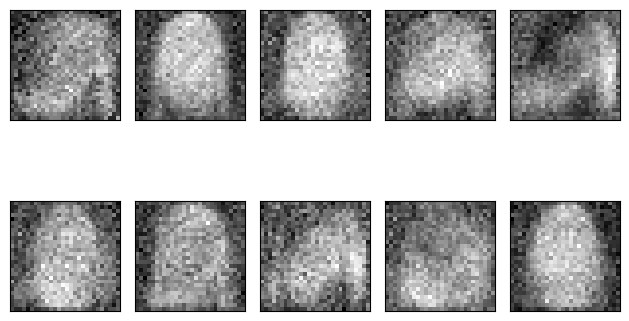

Training is complete


In [14]:
with tf.device('/gpu:0'):
     for epoch in range(epochs):
        print(f"Currently on Epoch {epoch+1}")


        for i in range(train_images.shape[0]//batch_size):

            if (i+1)%10 == 0:
                print(f"\tCurrently on batch number {i+1} of {train_images.shape[0]//batch_size}")

            noise=np.random.normal(size=[batch_size,noise_shape])

            gen_image = generator_3.predict_on_batch(noise)

            train_dataset = train_images[i*batch_size:(i+1)*batch_size]

            #training discriminator on real images
            train_label=np.ones(shape=(batch_size,1))
            discriminator_3.trainable = True
            d_loss_real=discriminator_3.train_on_batch(train_dataset,train_label)

            #training discriminator on fake images
            train_label=np.zeros(shape=(batch_size,1))
            d_loss_fake=discriminator_3.train_on_batch(gen_image,train_label)


            #training generator 
            noise=np.random.normal(size=[batch_size,noise_shape])
            train_label=np.ones(shape=(batch_size,1))
            discriminator_3.trainable = False

            d_g_loss_batch =GAN.train_on_batch(noise, train_label)




        #plotting generated images at the start and then after every 10 epoch
        if epoch % 3 == 0:
            samples = 10
            x_fake = generator_3.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()

        
        
print('Training is complete')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 524ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
FID Score: 2.9931553532536892e+51


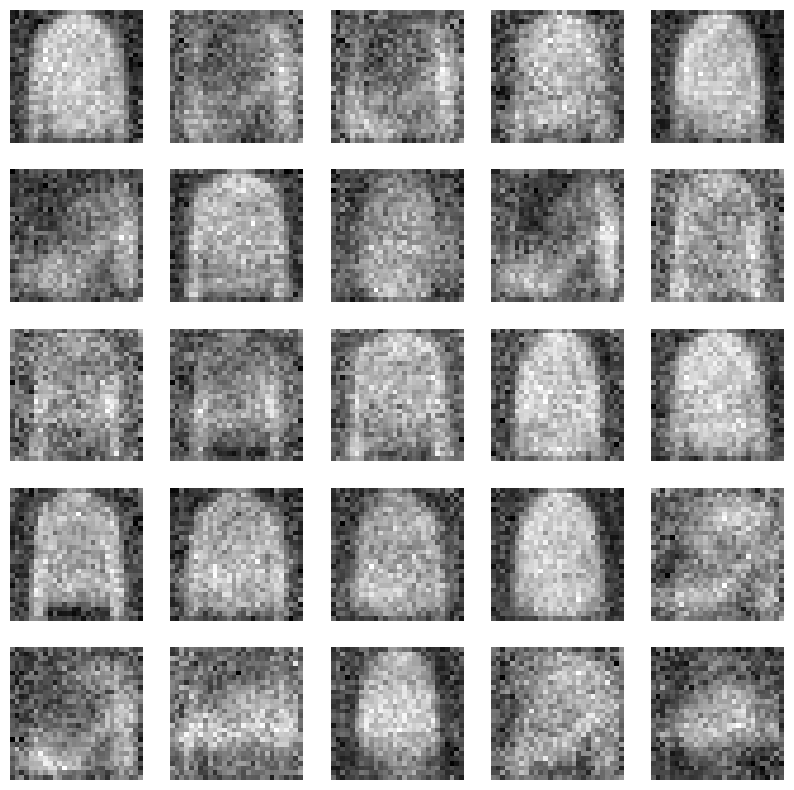

In [15]:
# Generate fake images
noise = tf.random.normal([1000, 100])
generated_images_3 = generator_3(noise, training=False)

# Calculate FID
fid = calculate_fid(test_images[:1000], generated_images_3)
print(f"FID Score: {fid}")

# Display some generated images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images_3[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

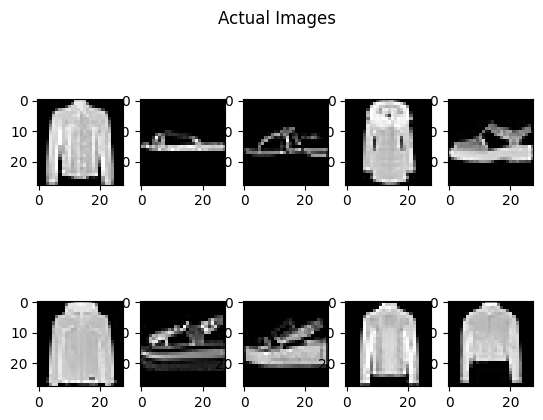

In [16]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(train_images[idx].reshape(28,28),cmap='gray')
        idx+=10

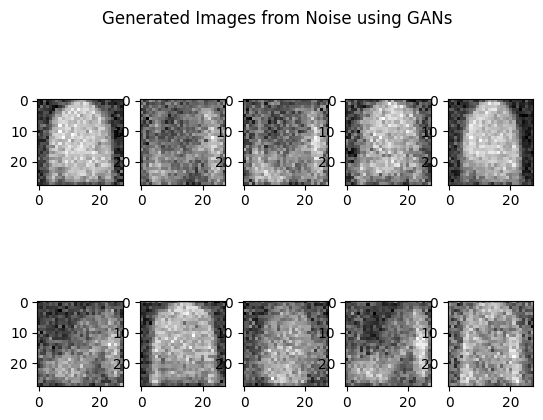

In [18]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(generated_images_3[idx],cmap='gray')
         idx+=1

#### Model 3: model 3 merupkan model yang paling baik sejauh ini, walaupun dengan jumlah epoch yang terbilang kecil hanya 10 epoch, tetapi model dapat menghasilkan gambar yang baik dimana sudah mulai terlihat terdapat beberapa shading pada gambar yang terlihat seperti sepatu dan coat, sehinggi ini membuktikan bahwa kedua hipotesa yang tadi saya buat adalah benar untuk model pertama. jika model ini diberikan epoch yang lebih tinggi atau waktu training yang lebih lama mungkin saja model dapat menghasilkan gambar yang lebih baik dari pada gambar yang digenerate saat ini 